In [1]:
import matplotlib.pyplot as plt
import monai
import numpy as np
import torch
from monai.transforms import Compose, LoadImaged, Resized
from monai.data import DataLoader, Dataset
from pathlib import Path
from monai.transforms.utils import allow_missing_keys_mode
from monai.transforms import BatchInverseTransform
from monai.networks.nets import ResNet
import nibabel as nib
from tqdm import tqdm
import medpy.metric as metric
import os
import seaborn as sns  
from sklearn.metrics import confusion_matrix, precision_score, recall_score

os.chdir('/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga')

In [2]:
def get_bugnist_2D_Data(dataset_path):
    dataset = []
    classes = os.listdir(dataset_path)
    for i, class_ in enumerate(classes):
        folders = os.listdir(os.path.join(dataset_path, class_))
        one_hot_encoded_label = np.zeros(len(classes))
        one_hot_encoded_label[i] = 1
        for folder in folders:
            # list only npy files
            files = [f for f in os.listdir(os.path.join(dataset_path, class_, folder)) if f.endswith('.npy')]#os.listdir(os.path.join(dataset_path, class_, folder))
            dataset.append({'projection_01': os.path.join(dataset_path, class_, folder, files[0]),
                        'projection_02': os.path.join(dataset_path, class_, folder, files[1]),
                        'projection_03': os.path.join(dataset_path, class_, folder, files[2]),
                        'label': one_hot_encoded_label,
                        'class': class_})
        
    return dataset


In [3]:
DATA_PATH = "data"
dataset = get_bugnist_2D_Data(DATA_PATH)
train_split = 0.8
test_split = 0.2
test_size = int(len(dataset) * test_split)
train_size = int(len(dataset) * train_split)
val_size = int(train_size*0.2)
train_size = train_size - val_size

idx = np.random.permutation(len(dataset))
train_idx = idx[:train_size]
val_idx = idx[train_size:train_size+val_size]
test_idx = idx[train_size+val_size:]

train_files = [dataset[i] for i in train_idx]
val_files = [dataset[i] for i in val_idx]
test_files = [dataset[i] for i in test_idx]


In [4]:
train_transforms = Compose([
    LoadImaged(keys=['projection_01', 'projection_02', 'projection_03'], ensure_channel_first=True),
    Resized(keys=['projection_01', 'projection_02', 'projection_03'], spatial_size=(64, 64))
])
val_transforms = Compose([
    LoadImaged(keys=['projection_01', 'projection_02', 'projection_03'], ensure_channel_first=True),
    Resized(keys=['projection_01', 'projection_02', 'projection_03'], spatial_size=(64, 64))
])
test_transforms = Compose([
    LoadImaged(keys=['projection_01', 'projection_02', 'projection_03'], ensure_channel_first=True),
    Resized(keys=['projection_01', 'projection_02', 'projection_03'], spatial_size=(64, 64))
])

train_dataset = Dataset(data=train_files, transform=train_transforms)
val_dataset = Dataset(data=val_files, transform=val_transforms)
test_dataset = Dataset(data=test_files, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=6)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=6)

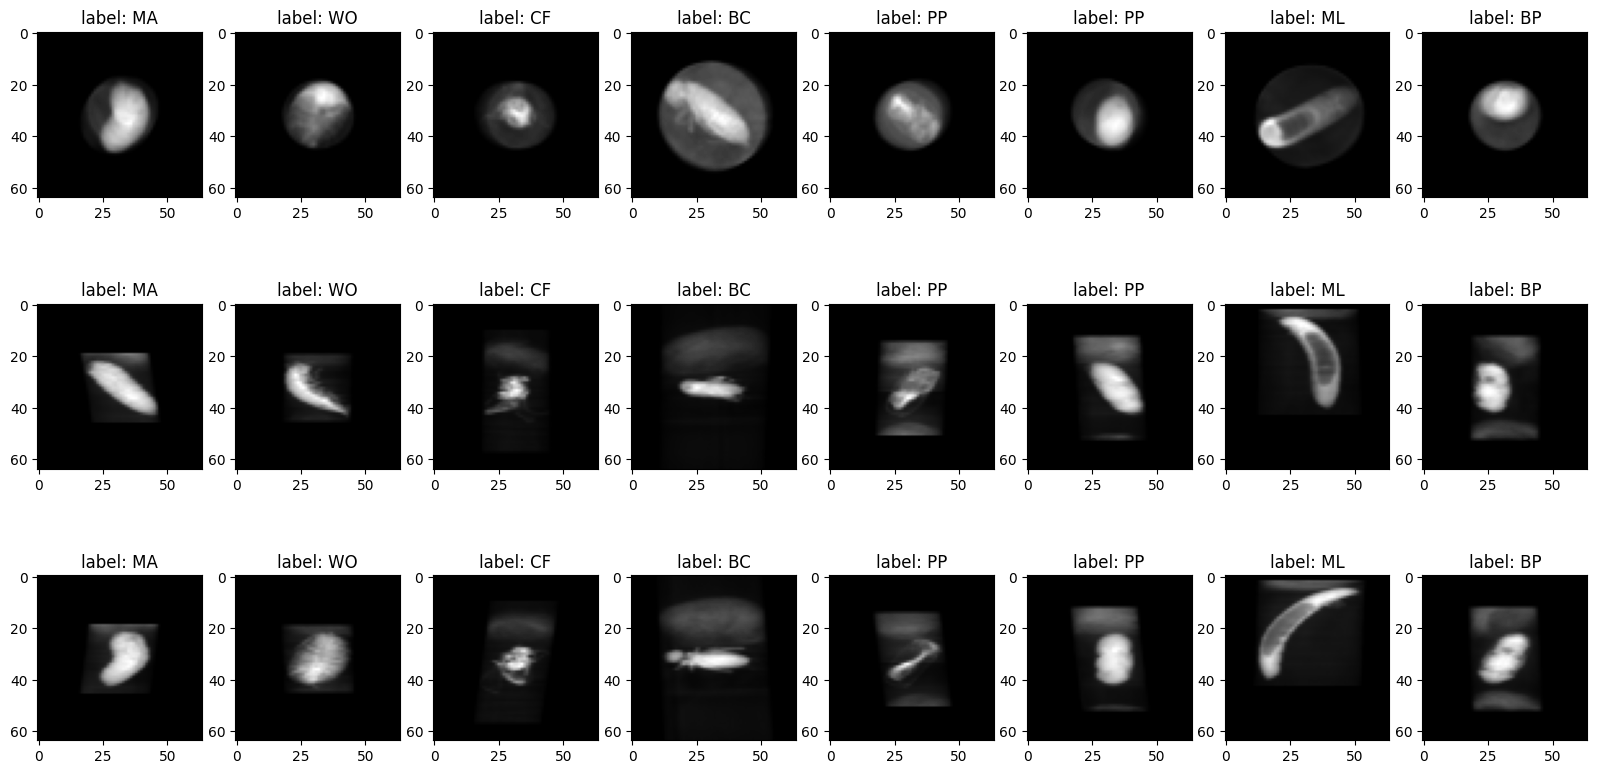

In [5]:
# Visualize one batch
batch = next(iter(train_loader))

classes = batch['class']

fig, ax = plt.subplots(3, 8, figsize=(20, 10))
for j in range(3):
    images = batch[f'projection_0{j+1}']
    for i in range(8):
        ax[j,i].imshow(images[i, 0, :, :], cmap='gray')
        ax[j,i].set_title('label: '+ classes[i])
plt.show()


## Training 

In [6]:
NUM_EPOCHS = 40
EVAL_EVERY = 1
BATCH_SIZE = 32

In [7]:
model = ResNet(block = 'basic',
                layers = [3, 4, 6, 3],
                spatial_dims=2, 
                n_input_channels=3,
                num_classes = 12,
                block_inplanes = [16, 32, 64, 128]
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)



loss_fn = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
inferer = monai.inferers.SliceInferer(roi_size=[-1, -1], spatial_dim=2, sw_batch_size=1)


In [ ]:
print("The model was defined. Training has started.")

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []

for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch + 1}')

    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    steps = 0
    train_targets_all = []
    train_predictions_all = []

    for tr_data in tqdm(train_loader):
        inputs = torch.cat([
            tr_data['projection_01'],
            tr_data['projection_02'],
            tr_data['projection_03']
        ], dim=1).cuda() 
    
        targets = tr_data['label'].cuda()
    
        # Forward -> Backward -> Step
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, torch.max(targets, 1)[1])
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == torch.max(targets, 1)[1]).sum().item()
        train_targets_all.extend(torch.max(targets, 1)[1].cpu().numpy())
        train_predictions_all.extend(predicted.cpu().numpy())

        epoch_loss += loss.detach().item()
        steps += 1

    train_losses.append(epoch_loss / steps)
    train_accuracies.append(100 * correct / total)
    train_precisions.append(precision_score(train_targets_all, train_predictions_all, average='macro'))
    train_recalls.append(recall_score(train_targets_all, train_predictions_all, average='macro'))
    print(f'Mean training loss: {train_losses[-1]}')
    print(f'Training accuracy: {train_accuracies[-1]}%')

    # Validation
    model.eval()
    epoch_loss = 0
    correct = 0
    total = 0
    steps = 0
    val_targets_all = []
    val_predictions_all = []

    with torch.no_grad():
        for val_data in tqdm(val_loader):
            inputs = torch.cat([
                val_data['projection_01'],
                val_data['projection_02'],
                val_data['projection_03']
            ], dim=1).cuda()
            targets = val_data['label'].cuda()

            outputs = model(inputs)
            loss = loss_fn(outputs, torch.max(targets, 1)[1])

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == torch.max(targets, 1)[1]).sum().item()
            val_targets_all.extend(torch.max(targets, 1)[1].cpu().numpy())
            val_predictions_all.extend(predicted.cpu().numpy())

            epoch_loss += loss.item()
            steps += 1

        val_losses.append(epoch_loss / steps)
        val_accuracies.append(100 * correct / total)
        val_precisions.append(precision_score(val_targets_all, val_predictions_all, average='macro'))
        val_recalls.append(recall_score(val_targets_all, val_predictions_all, average='macro'))
        print(f'Mean validation loss: {val_losses[-1]}')
        print(f'Validation accuracy: {val_accuracies[-1]}%')
        
# save the model
torch.save(model.state_dict(), "/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga/project/2D_results/model.pth")


The model was defined. Training has started.
Epoch 1


  0%|                                                   | 0/733 [00:00<?, ?it/s]

## Validation metrics

In [ ]:
# training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga/project/2D_results/loss_plot.png", bbox_inches='tight')

# accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig("/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga/project/2D_results/accuracy_plot.png", bbox_inches='tight')

# precision
plt.figure(figsize=(10, 5))
plt.plot(train_precisions, label='Training precision')
plt.plot(val_precisions, label='Validation precision')
plt.title('Training & Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.savefig("/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga/project/2D_results/precision_plot.png", bbox_inches='tight')

# recall
plt.figure(figsize=(10, 5))
plt.plot(train_recalls, label='Training recall')
plt.plot(val_recalls, label='Validation recall')
plt.title('Training & Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.savefig("/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga/project/2D_results/recall_plot.png", bbox_inches='tight')

## Confusion metrics

In [ ]:
# load the saved model
model_path = "/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga/project/2D_results/model.pth"
model.load_state_dict(torch.load(model_path))

model.eval()
model.to('cuda')

all_labels = []
all_predictions = []

with torch.no_grad():
    for data in test_loader:
        inputs = torch.cat([
            data['projection_01'],
            data['projection_02'],
            data['projection_03']
        ], dim=1).cuda()
        labels = data['label'].cuda()

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(torch.max(labels, 1)[1].cpu().numpy())

# confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 
               'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12']  # i will modify later

# Plotting the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for Test Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig("/dtu/3d-imaging-center/courses/02510/groups/group_Anhinga/Aleksandra/DL-3D-Anhinga/project/2D_results/test_confusion_matrix.png")
plt.show()